*Link Video:* https://drive.google.com/file/d/1HaBSugz1S4etSpA1z_DLRA6ATs3McHZR/view?usp=sharing

## Import Libraries and Dataset

In [36]:
# Import libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Tensorflow library
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import kerastuner as kt

# Sklearn library
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

# Set seed
SEED = 40
tf.keras.utils.set_random_seed(SEED)

# Global Variable
NOISE_MEAN = 0
NOISE_STD = 0.1

C:\Users\asus\AppData\Local\Temp\ipykernel_32440\3626970257.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
# Make path images in dataframe

data_path = "../B_23" # adjust with your own directory
file_paths = [os.path.join(data_path, filename) for filename in os.listdir(data_path)]
df = pd.DataFrame(file_paths, columns=["path"])
df.head()

,path
0,../B_23\kirmizi 1000.jpg
1,../B_23\kirmizi 1001.jpg
2,../B_23\kirmizi 1002.jpg
3,../B_23\kirmizi 1003.jpg
4,../B_23\kirmizi 1004.jpg


## EDA

Let's see our sample image

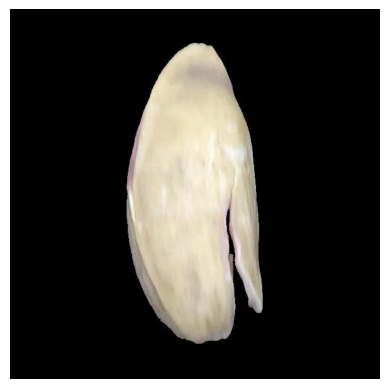

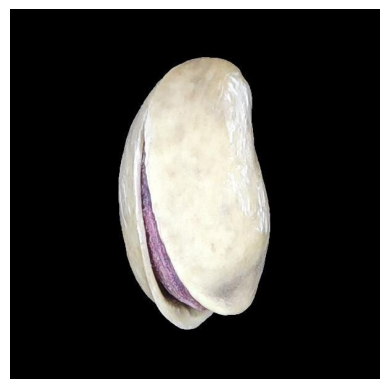

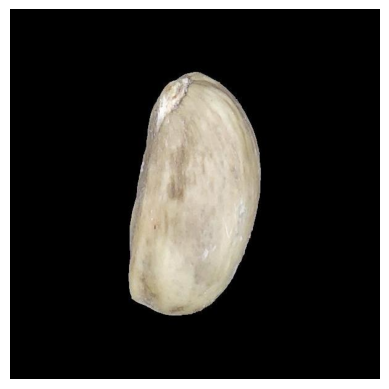

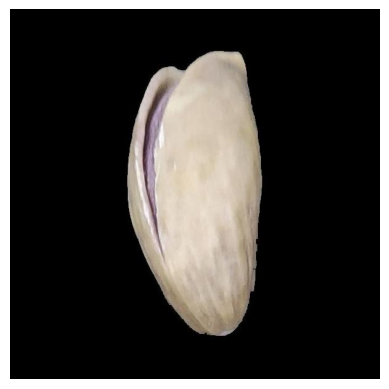

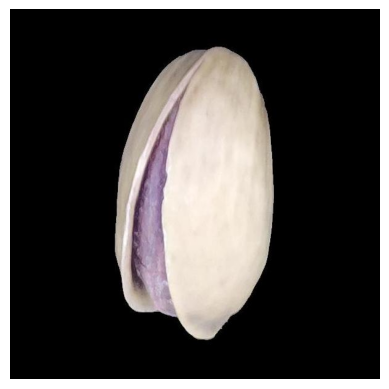

In [3]:
def plot_image(n):
    for i in range(n):
        image = Image.open(df["path"][i])
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        
plot_image(5)

Check RGB statistic from our data

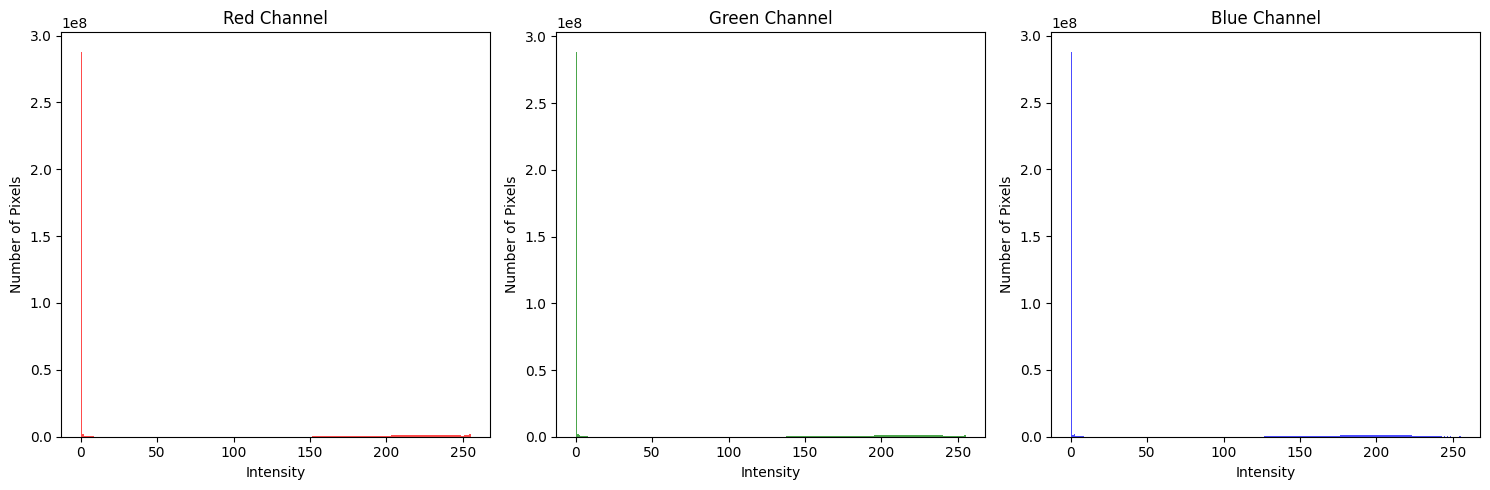

In [4]:
def get_rgb_pixels(image_path):
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]
    return r.size, r, g, b 

all_r, all_g, all_b = [], [], []
for path in df['path']:
    pixel_count, r, g, b = get_rgb_pixels(path)
    all_r.append(r.flatten())
    all_g.append(g.flatten())
    all_b.append(b.flatten())

all_r_flat = np.concatenate(all_r)
all_g_flat = np.concatenate(all_g)
all_b_flat = np.concatenate(all_b)


plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title('Red Channel')
plt.hist(all_r_flat, bins=256, range=(0, 255), color='red', alpha=0.7)
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')

plt.subplot(132)
plt.title('Green Channel')
plt.hist(all_g_flat, bins=256, range=(0, 255), color='green', alpha=0.7)
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')

plt.subplot(133)
plt.title('Blue Channel')
plt.hist(all_b_flat, bins=256, range=(0, 255), color='blue', alpha=0.7)
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')

plt.tight_layout()
plt.show()

Because most of them are black background, so there are lot of 0 pixel values, and the rest are between 150-250 pixel values

In [ ]:
# Get image information
def extract_image_info(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        total_pixel = width * height
        mode = img.mode
        
        img_arr = np.array(img)
        shape = img_arr.shape
        return {
            "width": width,
            "height": height,
            "total_pixel": total_pixel,
            "mode": mode,
            "shape": shape
        }
        
image_info = df["path"].apply(extract_image_info)
df_info = pd.DataFrame(list(image_info))

In [6]:
df_info.head()

,width,height,total_pixel,mode,shape
0,600,600,360000,RGB,"(600, 600, 3)"
1,600,600,360000,RGB,"(600, 600, 3)"
2,600,600,360000,RGB,"(600, 600, 3)"
3,600,600,360000,RGB,"(600, 600, 3)"
4,600,600,360000,RGB,"(600, 600, 3)"


In [7]:
df_info.describe()

,width,height,total_pixel
count,1074.0,1074.0,1074.0
mean,600.0,600.0,360000.0
std,0.0,0.0,0.0
min,600.0,600.0,360000.0
25%,600.0,600.0,360000.0
50%,600.0,600.0,360000.0
75%,600.0,600.0,360000.0
max,600.0,600.0,360000.0


In [8]:
df_info["mode"].value_counts()

mode
RGB    1074
Name: count, dtype: int64

All of the image are in same format (600, 600, 3) with total pixel 360k in RGB format, so we're good to next preprocessing step

## Data Preprocessing

Create image data in numpy and add gaussian noise

In [ ]:
def process_path(path):
    """
    Process our image from path, resize to (100,100), scale to [0,1] and add noise
    """

    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [100, 100])
    img = tf.cast(img, tf.float32) / 255.0
    
    noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.1, seed=SEED)
    noisy_img = img + noise
    noisy_img = tf.clip_by_value(noisy_img, 0.0, 1.0)
    
    return noisy_img

Process our image into array

In [10]:
all_image = []
for path in df["path"].values:
    img_tensor = process_path(path)
    img_np = img_tensor.numpy()
    all_image.append(img_np)


In [11]:
all_image_np = np.array(all_image)
print(all_image_np.shape)

(1074, 100, 100, 3)


Splitting the data into 80% train, 10% validation and 10% test

In [12]:
train_ds, temp_ds = train_test_split(all_image_np, test_size=0.2, random_state=SEED)
test_ds, val_ds = train_test_split(temp_ds, test_size=0.5, random_state=SEED)

In [13]:
print("Train size     : ", train_ds.shape)
print("Validation size: ", val_ds.shape)
print("Test size      : ", test_ds.shape)


Train size     :  (859, 100, 100, 3)
Validation size:  (108, 100, 100, 3)
Test size      :  (107, 100, 100, 3)


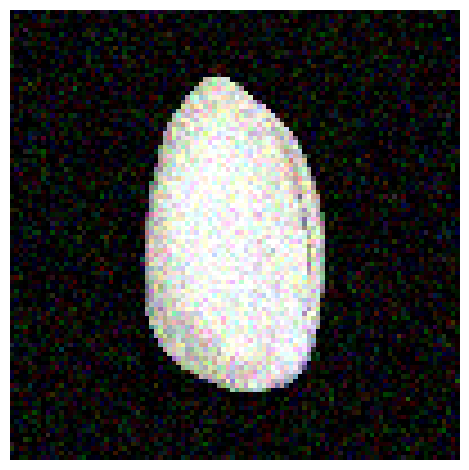

In [14]:
plt.imshow(train_ds[1])
plt.axis("off")
plt.tight_layout()

## Modelling

### Baseline Model

After we create the dataset with masked patch, now we're good to modelling.

Encoder:
| Layer (Type)                     | Output Shape           |
| -------------------------------- | ---------------------- |
| `input_layer` (InputLayer)       | `(None, 100, 100, 3)`  |
| `conv2d` (Conv2D)                | `(None, 100, 100, 32)` |
| `max_pooling2d` (MaxPooling2D)   | `(None, 50, 50, 32)`   |
| `conv2d_1` (Conv2D)              | `(None, 50, 50, 64)`   |
| `max_pooling2d_1` (MaxPooling2D) | `(None, 25, 25, 64)`   |
| `conv2d_2` (Conv2D)              | `(None, 25, 25, 64)`   |

Decoder:
| Layer (Type)                     | Output Shape           |
| -------------------------------- | ---------------------- |
| `up_sampling2d` (UpSampling2D)   | `(None, 50, 50, 64)`   |
| `conv2d_3` (Conv2D)              | `(None, 50, 50, 32)`   |
| `up_sampling2d_1` (UpSampling2D) | `(None, 100, 100, 32)` |
| `conv2d_4` (Conv2D)              | `(None, 100, 100, 3)`  |


In [15]:
callbacks_baseline = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss'),
    ModelCheckpoint('models2/baseline/best_model.h5', save_best_only=True, monitor='val_loss')
]

In [16]:
def baseline_autoencoder():
    input_layer = Input(shape=(100, 100, 3))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x) 
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mse', 'mae'])

    return autoencoder

autoencoder = baseline_autoencoder()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        36928 

c:\Users\asus\anaconda3\envs\tf210\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
baseline = autoencoder.fit(
    train_ds, train_ds, 
    epochs=50,
    batch_size=32,
    validation_data=(val_ds, val_ds),
    callbacks=callbacks_baseline
)

Epoch 1/50
27/27 [==============================] - 5s 42ms/step - loss: 0.0600 - mse: 0.0600 - mae: 0.1768 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0633 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 1s 21ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0601 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0587 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 1s 21ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0579 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0574 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 1s 21ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0566 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0558 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 1s 21ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0556 - val_loss: 0.0078 - val_mse: 0.0078 - val_mae: 0.0550 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 1s 21ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0548 - val_loss: 

### Modification model

The modification model is adapt from U-Net model architecture

**Encoder:**

| **Layer (Type)**        | **Output Shape**        |
|-------------------------|--------------------------|
| `input_layer` (InputLayer) | (None, 100, 100, 3)     |
| `conv2d` (Conv2D)         | (None, 100, 100, 32)     |
| `max_pooling2d` (MaxPooling2D) | (None, 50, 50, 32)  |
| `conv2d_1` (Conv2D)       | (None, 50, 50, 64)       |
| `max_pooling2d_1` (MaxPooling2D) | (None, 25, 25, 64) |
| `conv2d_2` (Conv2D)       | (None, 25, 25, 256)      |


**Decoder:**

| **Layer (Type)**        | **Output Shape**        |
|-------------------------|--------------------------|
| `up_sampling2d` (UpSampling2D)   | (None, 50, 50, 256)  |
| `concatenate` (Concatenate)      | (None, 50, 50, 320)  |
| `conv2d_3` (Conv2D)              | (None, 50, 50, 64)   |
| `up_sampling2d_1` (UpSampling2D) | (None, 100, 100, 64) |
| `concatenate_1` (Concatenate)    | (None, 100, 100, 96) |
| `conv2d_4` (Conv2D)              | (None, 100, 100, 32) |
| `output` (Conv2D)                | (None, 100, 100, 3)  |

**Key Features**

- **Skip Connections**: Improve gradient flow and help preserve spatial details by concatenating encoder feature maps with decoder maps.
- **Batch Normalization**: Applied after every convolution to stabilize and speed up training.
- **Symmetric Design**: Each encoder block has a matching decoder block in reverse.

In [18]:
callbacks_modification = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss'),
    ModelCheckpoint('models2/modification/best_model.h5', save_best_only=True, monitor='val_loss')
]

In [19]:
def conv_block(x, filters, n_convs=2):
    for _ in range(n_convs):
        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = MaxPooling2D((2,2), padding='same')(c)
    return c, p

def decoder_block(x, skip, filters):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, skip])
    c = conv_block(c, filters)
    return c

In [20]:
def modified_autoencoder():
    inputs = Input(shape=(100, 100, 3))

    # Encoder
    c1, p1 = encoder_block(inputs, 32)   
    c2, p2 = encoder_block(p1, 64)       
    # Bottleneck
    bn = conv_block(p2, 256, 1)

    # Decoder
    d2 = decoder_block(bn, c2, 64) 
    d1 = decoder_block(d2, c1, 32)
    
    # Output layer
    outputs = Conv2D(3, 3, activation='sigmoid', padding='same')(d1)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='mse',
        metrics=['mse', 'mae']
    )
    return model

modification = modified_autoencoder()
modification.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 100, 100, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 100, 32  128        ['conv2d_5[0][0]']               
 alization)                     )                                                           

In [21]:
modification_model = modification.fit(
    train_ds, train_ds, 
    epochs=50,
    batch_size=32,
    validation_data=(val_ds, val_ds),
    callbacks=callbacks_modification
)

Epoch 1/50
27/27 [==============================] - 8s 185ms/step - loss: 0.0347 - mse: 0.0347 - mae: 0.1466 - val_loss: 0.0825 - val_mse: 0.0825 - val_mae: 0.2619 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 3s 118ms/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0618 - val_loss: 0.0408 - val_mse: 0.0408 - val_mae: 0.1873 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 3s 107ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0533 - val_loss: 0.0700 - val_mse: 0.0700 - val_mae: 0.2105 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 3s 104ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0492 - val_loss: 0.0953 - val_mse: 0.0953 - val_mae: 0.2112 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 3s 104ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0447 - val_loss: 0.1045 - val_mse: 0.1045 - val_mae: 0.2183 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 3s 104ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0412 - val_

### Hyperparameter tuning Model

In [34]:
callbacks_hyper = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss'),
    ModelCheckpoint('models2/hyper/best_model.h5', save_best_only=True, monitor='val_loss')
]

In [35]:
def build_autoencoder_hp(hp):
    inputs = Input(shape=(100, 100, 3))

    # Encoder
    f1 = hp.Int('filters1', min_value=16, max_value=64, step=16)
    c1, p1 = encoder_block(inputs, filters=f1)

    f2 = hp.Int('filters2', min_value=32, max_value=128, step=32)
    c2, p2 = encoder_block(p1, filters=f2)

    # Bottleneck
    bn_convs = hp.Choice('bn_convs', [1, 2])
    bn = conv_block(p2, filters=hp.Int('bn_filters', 64, 256, step=64), n_convs=bn_convs)

    # Decoder
    d2 = decoder_block(bn, c2, filters=f2)
    d1 = decoder_block(d2, c1, filters=f1)

    outputs = Conv2D(3, 3, activation='sigmoid', padding='same')(d1)
    model = Model(inputs, outputs)

    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mse', 'mae']
    )
    return model

In [37]:
tuner = kt.RandomSearch(
    build_autoencoder_hp,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_runs',
    project_name='ae_tuning'
)

In [39]:
tuner.search(
    train_ds, train_ds,
    epochs=20,
    batch_size=32,
    validation_data=(val_ds, val_ds),
    callbacks=callbacks_hyper
)

tuner.results_summary()

best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 35s]
val_loss: 0.06392621248960495

Best val_loss So Far: 0.004142228048294783
Total elapsed time: 00h 24m 45s
Results summary
Results in kt_runs\ae_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
filters1: 64
filters2: 32
bn_convs: 2
bn_filters: 192
learning_rate: 0.00019566016366917262
Score: 0.004142228048294783

Trial 06 summary
Hyperparameters:
filters1: 16
filters2: 96
bn_convs: 2
bn_filters: 128
learning_rate: 0.00020712240848119796
Score: 0.006173721980303526

Trial 00 summary
Hyperparameters:
filters1: 16
filters2: 96
bn_convs: 2
bn_filters: 128
learning_rate: 0.00020209047379654788
Score: 0.010641046799719334

Trial 02 summary
Hyperparameters:
filters1: 16
filters2: 128
bn_convs: 2
bn_filters: 64
learning_rate: 0.0037607167682912265
Score: 0.01122343074530363

Trial 05 summary
Hyperparameters:
filters1: 48
filters2: 96
bn_convs: 2
bn_filters: 256
learning_rate: 0.004008276646393039
Score: 

## Evaluation

### SSIM Metrics

**SSIM (Structural Similarity Index)** is a perceptual metric used to measure the similarity between two images. Unlike traditional metrics such as Mean Squared Error (MSE), SSIM focuses on capturing **visual similarity** in terms of:

- **Luminance** (brightness)
- **Contrast**
- **Structural patterns** (edges, textures)

---

**SSIM Score Range**

| SSIM Value      | Interpretation                         |
|-----------------|-----------------------------------------|
| **1.0**         | Perfect match (images are identical)    |
| **0.9 – 1.0**   | Excellent similarity                    |
| **0.7 – 0.9**   | Good similarity                         |
| **0.5 – 0.7**   | Fair, noticeable differences            |
| **< 0.5**       | Poor similarity                         |

In [28]:
def ssim_score(val_ds, decoded_val):
    ssim_scores = []
    for orig, recon in zip(val_ds, decoded_val):
        score = ssim(
            orig, recon, data_range=1.0, channel_axis=-1)
        ssim_scores.append(score)
        
    ssim_scores = np.array(ssim_scores)
        
    return ssim_scores

### Baseline Evaluation

In [22]:
decoded_val = autoencoder.predict(val_ds, batch_size=32)

4/4 [==============================] - 0s 7ms/step


In [29]:
baseline_ssim = ssim_score(val_ds, decoded_val)

print(f"Average SSIM on val set: {baseline_ssim.mean():.4f}")
print(f"Min SSIM               : {baseline_ssim.min():.4f}")
print(f"Max SSIM               : {baseline_ssim.max():.4f}")

Average SSIM on val set: 0.3396
Min SSIM               : 0.3159
Max SSIM               : 0.3730


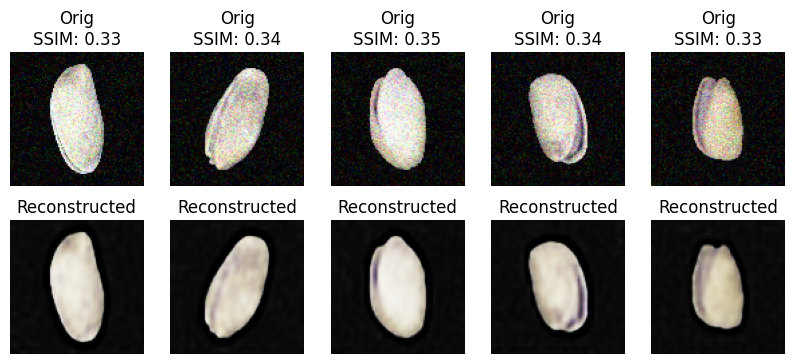

In [ ]:
n = 5  # ambil 5 contoh pertama
plt.figure(figsize=(10, 4))
for i in range(n):
    # Asli
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_ds[i])
    plt.title(f"Orig\nSSIM: {baseline_ssim[i]:.2f}")
    plt.axis("off")

    # Rekonstruksi
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_val[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()

### Modification evaluation

In [31]:
decoded_val = modification.predict(val_ds, batch_size=32)

4/4 [==============================] - 1s 134ms/step


In [32]:
modification_ssim = ssim_score(val_ds, decoded_val)

print(f"Average SSIM on val set: {modification_ssim.mean():.4f}")
print(f"Min SSIM               : {modification_ssim.min():.4f}")
print(f"Max SSIM               : {modification_ssim.max():.4f}")

Average SSIM on val set: 0.1614
Min SSIM               : 0.1262
Max SSIM               : 0.1846


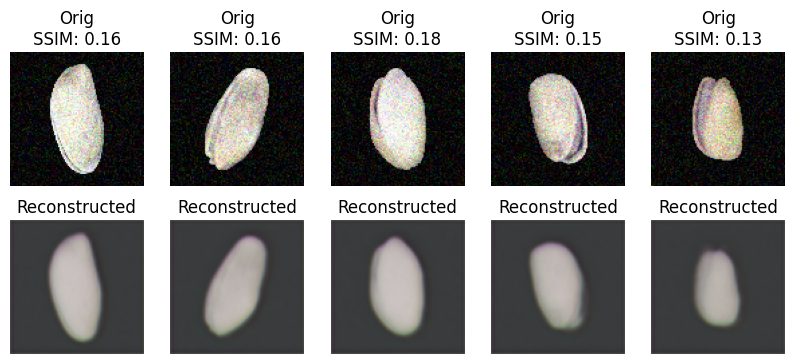

In [ ]:
n = 5 
plt.figure(figsize=(10, 4))
for i in range(n):
    
    # Original Image
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_ds[i])
    plt.title(f"Orig\nSSIM: {modification_ssim[i]:.2f}")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_val[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()

### Hyperparameter tuning Evaluation

In [40]:
decoded_val = best_model.predict(val_ds)

4/4 [==============================] - 1s 147ms/step


In [41]:
hyper_ssim = ssim_score(val_ds, decoded_val)

print(f"Average SSIM on val set: {hyper_ssim.mean():.4f}")
print(f"Min SSIM               : {hyper_ssim.min():.4f}")
print(f"Max SSIM               : {hyper_ssim.max():.4f}")

Average SSIM on val set: 0.7947
Min SSIM               : 0.7684
Max SSIM               : 0.8190


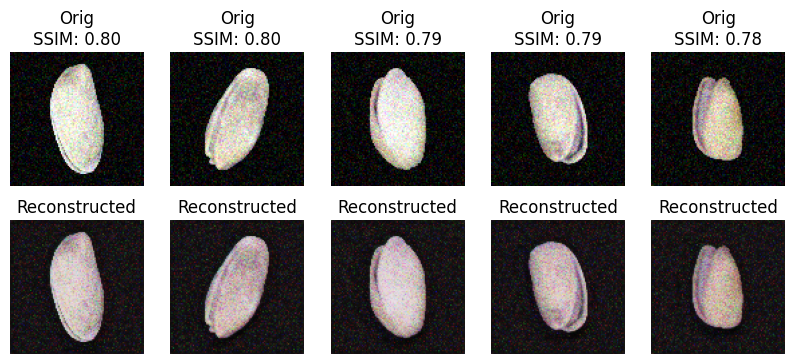

In [47]:
n = 5 
plt.figure(figsize=(10, 4))
for i in range(n):
    
    # Original Image
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_ds[i])
    plt.title(f"Orig\nSSIM: {hyper_ssim[i]:.2f}")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_val[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()

Hyper tuning the base model increase the performance twice and even better, So in this case, hyperparameter tuning autoencoder model is the best model we could choose based on the SSIM value around 0.8 that means almost 80% 

In [46]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best parameter: ", best_hp.values)

Best parameter:  {'filters1': 64, 'filters2': 32, 'bn_convs': 2, 'bn_filters': 192, 'learning_rate': 0.00019566016366917262}
